# Import Libraries and CSV File, Activate GPU

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
#activating gpu... if able
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU enabled")
except:
    print("CPU enabled")
    pass

GPU enabled


In [3]:
df = pd.read_csv(filepath_or_buffer='player_data.csv', index_col=0) #importing csv file into single dataframe, 'df'
df = df.drop('goals', axis=1) #dropping target variable to be used in assists predictive system
df_labels = df.pop('assists').astype(int) #creating dataframe for labels, 'df_labels', and removing target variable from df

# Creating Helpful Functions

In [4]:
def create_model(model_input, X_train, X_val, y_train, y_val):
    """function for creating sklearn models"""
    model = model_input
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    r_squared = r2_score(y_val, y_pred)
    mae = mean_squared_error(y_val, y_pred)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    return model, r_squared, mae, rmse

def metrics(r2, mae, rmse):
    """function to see model evaluation metrics"""
    print('R2:', round(r2, 2) , 'MAE:', round(mae, 2), 'RMSE:', round(rmse, 2))

def perm_importance(feature_importance):
    """function to visualize permutation feature importance"""
    #sorting features by importance
    sorted_idx = feature_importance.importances_mean.argsort()
    
    #plotting feature importance figure
    plt.figure(figsize=(12, 6))
    plt.boxplot(feature_importance.importances[sorted_idx].T, vert=False, labels=X_val.columns[sorted_idx])
    plt.title("Permutation Importances (validation set)")
    plt.tight_layout()
    plt.show()

def coef_importance(feature_importance, X_train):
    """#to visualize important features for each model"""
    features = X_train.columns
    #converting coefficients to absolute value for comparison of magnetude
    importances = abs(feature_importance)
    
    #sorting the features based on importance
    sorted_idx = np.argsort(importances)
    sorted_importances = importances[sorted_idx]
    sorted_feature_names = [features[i] for i in sorted_idx]
    
    #creating the plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_importances)
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importances in Model')
    plt.tight_layout()
    plt.show()

def calculate_accuracy(predicted_arr, actual_arr, tolerance=5):
    """calculate the accuracy of predictions within a tolerance of 5 units for numpy arrays"""
    correct_predictions = np.sum(np.abs(predicted_arr - actual_arr) <= tolerance) #calculate the number of correct predictions
    accuracy = round((correct_predictions / predicted_arr.shape[0]) * 100, 2) #calculate accuracy

    return accuracy

def model_prediction(model, X_test, y_test):
    """function to generate model predictions"""
    y_pred = model.predict(X_test)
    y_pred = np.squeeze(np.round(y_pred, decimals=0).astype(int))
    y_actual = y_test.to_numpy(dtype=int)
        
    return y_pred, y_actual

### Train, Validation, Test Splitting

In [5]:
#splitting data to be 70% training, 15% validation, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(df, df_labels, test_size=0.3, random_state=42) #split training data from temporary data (validation and test)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42) #split temporary data into validation and test data

In [6]:
col_list = ['playerId', 'name']

X_train = X_train.drop(col_list, axis=1)
X_val = X_val.drop(col_list, axis=1)
X_test = X_test.drop(col_list, axis=1)

# Support Vector Regressor

In [7]:
svr_model, svr_r2, svr_mae, svr_rmse = create_model(SVR(), X_train, X_val, y_train, y_val)
svr_importance = permutation_importance(svr_model, X_val, y_val)
metrics(svr_r2, svr_mae, svr_rmse)

R2: 0.78 MAE: 34.78 RMSE: 5.9


In [8]:
y_pred_svr, y_actual_svr = model_prediction(svr_model, X_test, y_test)

In [9]:
accuracy = calculate_accuracy(y_pred_svr, y_actual_svr)
print(accuracy)

76.22


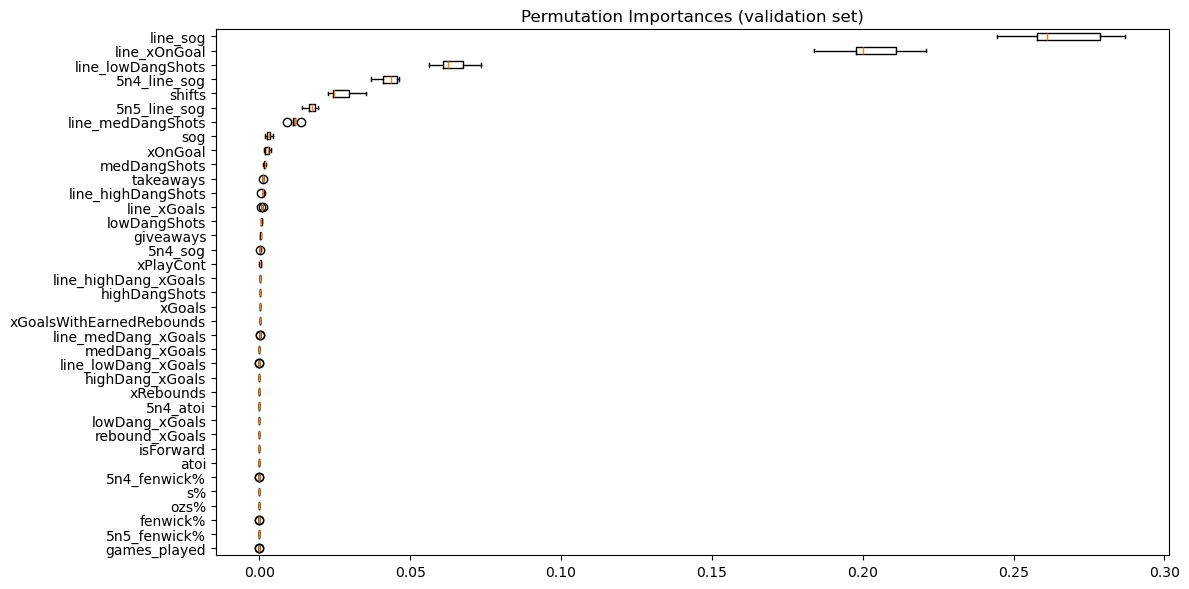

In [10]:
perm_importance(svr_importance)

# Linear Regression

In [11]:
linear_model, linear_r2, linear_mae, linear_rmse = create_model(LinearRegression(), X_train, X_val, y_train, y_val)
linear_importance = linear_model.coef_
metrics(linear_r2, linear_mae, linear_rmse)

R2: 0.84 MAE: 25.56 RMSE: 5.06


In [12]:
y_pred_linear, y_actual_linear = model_prediction(linear_model, X_test, y_test)

In [13]:
accuracy = calculate_accuracy(y_pred_linear, y_actual_linear)
print(accuracy)

77.8


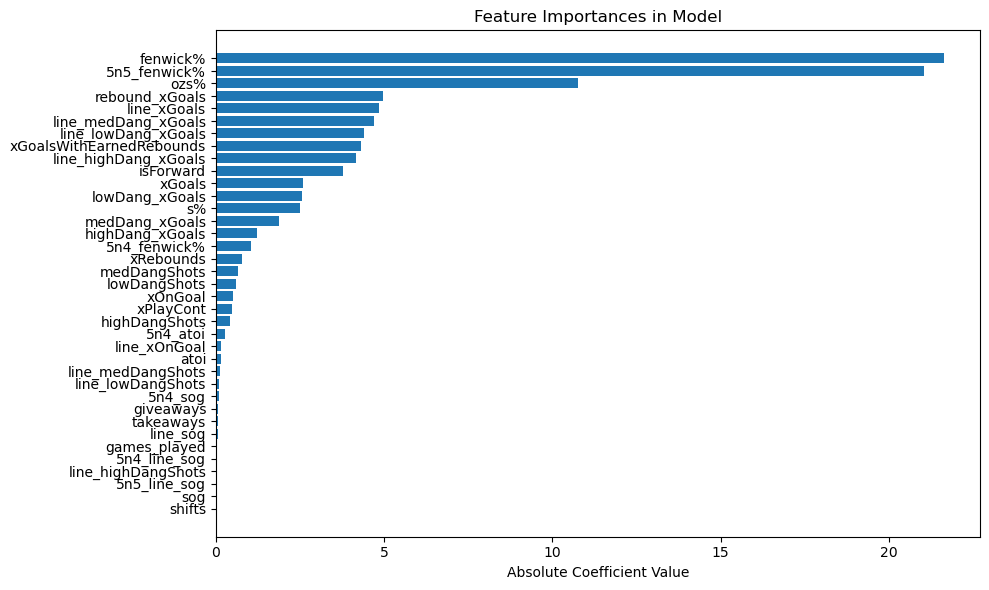

In [14]:
coef_importance(linear_importance, X_train)

# Elastic Net

In [15]:
elasticNet_model, en_r2, en_mae, en_rmse = create_model(ElasticNet(), X_train, X_val, y_train, y_val)
en_importance = elasticNet_model.coef_
metrics(en_r2, en_mae, en_rmse)

R2: 0.82 MAE: 28.34 RMSE: 5.32


In [16]:
y_pred_en, y_actual_en = model_prediction(elasticNet_model, X_test, y_test)

In [17]:
accuracy = calculate_accuracy(y_pred_en, y_actual_en)
print(accuracy)

76.1


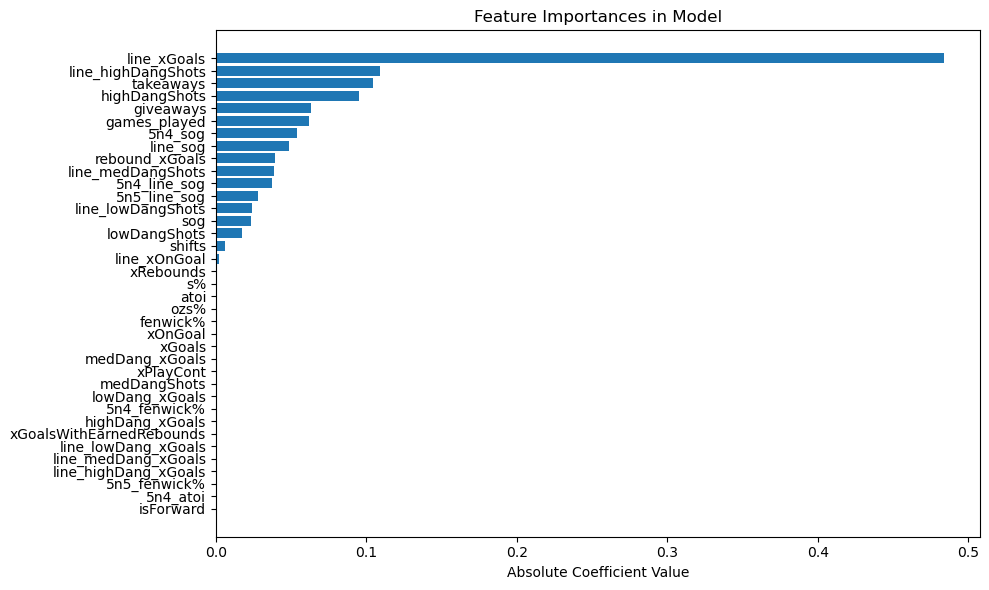

In [18]:
coef_importance(en_importance, X_train)

# Gradient Boosting

In [19]:
gb_model, gb_r2, gb_mae, gb_rmse = create_model(GradientBoostingRegressor(), X_train, X_val, y_train, y_val)
gb_importance = gb_model.feature_importances_
metrics(gb_r2, gb_mae, gb_rmse)

R2: 0.84 MAE: 24.95 RMSE: 4.99


In [20]:
y_pred_gb, y_actual_gb = model_prediction(gb_model, X_test, y_test)

In [21]:
accuracy = calculate_accuracy(y_pred_gb, y_actual_gb)
print(accuracy)

78.29


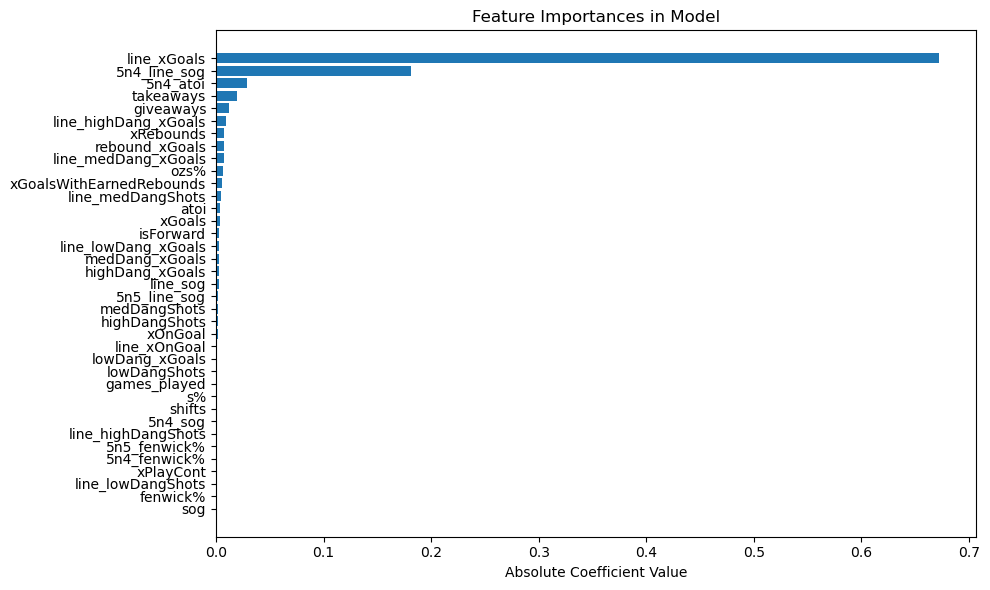

In [22]:
coef_importance(gb_importance, X_train)

# Random Forest

In [23]:
rf_model, rf_r2, rf_mae, rf_rmse = create_model(RandomForestRegressor(), X_train, X_val, y_train, y_val)
rf_importance = rf_model.feature_importances_
metrics(rf_r2, rf_mae, rf_rmse)

R2: 0.83 MAE: 26.14 RMSE: 5.11


In [24]:
y_pred_rf, y_actual_rf = model_prediction(rf_model, X_test, y_test)

In [25]:
accuracy = calculate_accuracy(y_pred_rf, y_actual_rf)
print(accuracy)

78.9


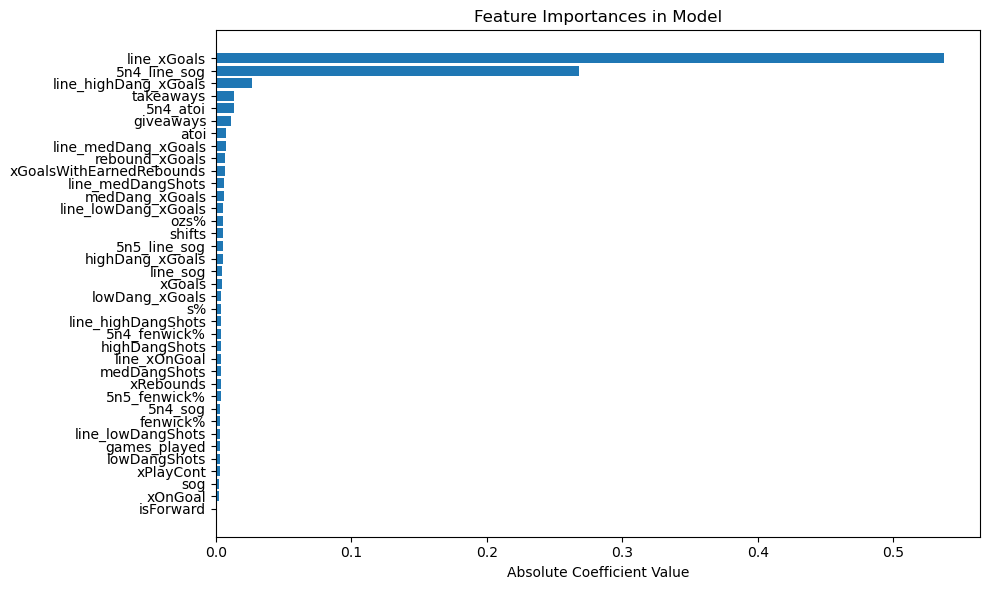

In [26]:
coef_importance(rf_importance, X_train)

# Neural Network

In [27]:
class RSquared(tf.keras.metrics.Metric):
    def __init__(self, name='r_squared', **kwargs):
        super(RSquared, self).__init__(name=name, **kwargs)
        self.sse = tf.keras.metrics.Sum()  #sum of squared errors
        self.sst = tf.keras.metrics.Sum()  #total sum of squares

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        error = y_true - y_pred
        squared_error = tf.square(error)
        self.sse.update_state(squared_error)

        mean_true = tf.reduce_mean(y_true)
        total_error = y_true - mean_true
        squared_total_error = tf.square(total_error)
        self.sst.update_state(squared_total_error)

    def result(self):
        return 1 - (self.sse.result() / self.sst.result())

    def reset_states(self):
        self.sse.reset_states()
        self.sst.reset_states()

In [43]:
shape = X_train.shape[1]

nn_model = tf.keras.models.Sequential()
nn_model.add(layers.Dense(64, input_dim=shape, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(64, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(64, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(128, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))
nn_model.add(layers.Dropout(0.125))

nn_model.add(layers.Dense(64, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))
nn_model.add(layers.Dropout(0.05))

nn_model.add(layers.Dense(64, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(32, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(32, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(16, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(8, kernel_initializer='he_normal'))
nn_model.add(layers.BatchNormalization())
nn_model.add(layers.Activation('relu'))

nn_model.add(layers.Dense(1, activation='linear'))

nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                2432      
                                                                 
 batch_normalization_20 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_21 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 64)               

In [44]:
nn_model.compile(loss='mae', optimizer='adam', metrics=[RSquared()])

In [45]:
#implementing early stoping to avoid overfitting and also just to prevent furhter uneccessary epochs.
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=25, mode='min')

hist=nn_model.fit(X_train, y_train, batch_size=128, validation_data=(X_val, y_val),
              epochs=150, verbose=1, callbacks=[es])

Epoch 1/150
30/30 [==============================] - 3s 31ms/step - loss: 16.6495 - r_squared: -1.5955 - val_loss: 20.5524 - val_r_squared: -2.9604
Epoch 2/150
30/30 [==============================] - 0s 15ms/step - loss: 16.2593 - r_squared: -1.5573 - val_loss: 18.9130 - val_r_squared: -2.4424
Epoch 3/150
30/30 [==============================] - 0s 15ms/step - loss: 15.9177 - r_squared: -1.4865 - val_loss: 17.4595 - val_r_squared: -2.0424
Epoch 4/150
30/30 [==============================] - 0s 15ms/step - loss: 15.6124 - r_squared: -1.4389 - val_loss: 16.6757 - val_r_squared: -1.8507
Epoch 5/150
30/30 [==============================] - 0s 15ms/step - loss: 15.3400 - r_squared: -1.3950 - val_loss: 16.1154 - val_r_squared: -1.7343
Epoch 6/150
30/30 [==============================] - 0s 16ms/step - loss: 15.0579 - r_squared: -1.3365 - val_loss: 15.7573 - val_r_squared: -1.6682
Epoch 7/150
30/30 [==============================] - 0s 17ms/step - loss: 14.7836 - r_squared: -1.2861 - val_los

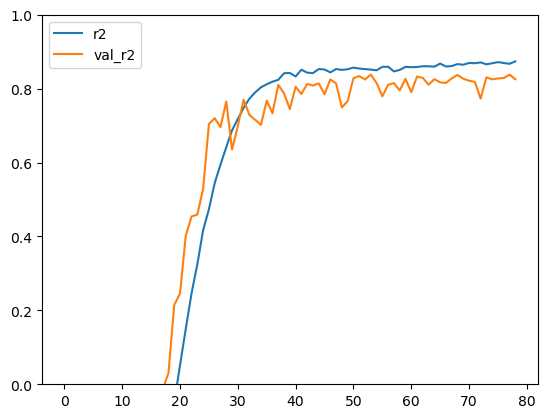

In [46]:
plt.plot(hist.history['r_squared'], label='r2')
plt.plot(hist.history['val_r_squared'], label='val_r2')
plt.ylim((0, 1))
plt.legend()

In [47]:
y_pred_nn, y_actual_nn = model_prediction(nn_model, X_test, y_test)

26/26 [==============================] - 0s 8ms/step


In [48]:
accuracy = calculate_accuracy(y_pred_nn, y_actual_nn)
print(accuracy)

77.2


# Prediction on Whole Dataset

In [34]:
df_ids = df[col_list] #col_list is a list containing the playerId and name column names
df = df.drop(col_list, axis=1)

In [35]:
y_pred, y_actual = model_prediction(rf_model, df, df_labels)
accuracy = calculate_accuracy(y_pred, y_actual)
print(accuracy)

92.22


In [36]:
accuracy = calculate_accuracy(y_pred, y_actual, 3)
print(accuracy)

83.39


In [37]:
accuracy = calculate_accuracy(y_pred, y_actual, 1)
print(accuracy)

57.28
